In [1]:
!pip install category_encoders

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import sqldf
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [5]:
#Defining the Path
file_path = r'C:\Users\vaibhav.bodhe\OneDrive - Inteliment Technologies India Pvt. Ltd\DESKTOP\2_filter.csv'

In [6]:
#Reading the Data
df = pd.read_csv(file_path)

In [7]:
#Converting Date attributes to date_time for applying different operations
df['srch_ci']=pd.to_datetime(df['srch_ci'])
df['srch_co']=pd.to_datetime(df['srch_co'])
df['date_time']=pd.to_datetime(df['date_time'])

In [8]:
#Extracting month from checkin date and date_time of user event to check seasonality
df['check_in_month']=df['srch_ci'].apply(lambda x:x.month)
df['date_time_month']=df['date_time'].apply(lambda x:x.month)

In [9]:
# Using only data which has is_booking = 1
df=df.drop(columns=['is_booking'])

In [10]:
#-------------------------EDA-----------------------#

In [11]:
df.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,check_in_month,date_time_month
0,1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,...,1,8250,1,1,2,50,628,1,8,8
1,79,2014-01-03 16:30:17,2,3,66,462,41898,2454.8588,1482,0,...,2,12009,1,1,2,50,680,95,2,1
2,81,2014-01-03 16:44:56,2,3,66,462,41898,2454.8588,1482,0,...,1,12009,1,1,2,50,680,95,2,1
3,83,2014-01-03 17:11:36,2,3,66,462,41898,2454.8588,1482,0,...,1,12009,1,1,2,50,680,95,2,1
4,128,2014-10-29 14:32:19,2,3,66,174,40365,8456.8294,1713,0,...,2,1571,3,1,3,5,89,38,11,10


<Axes: xlabel='hotel_continent', ylabel='count'>

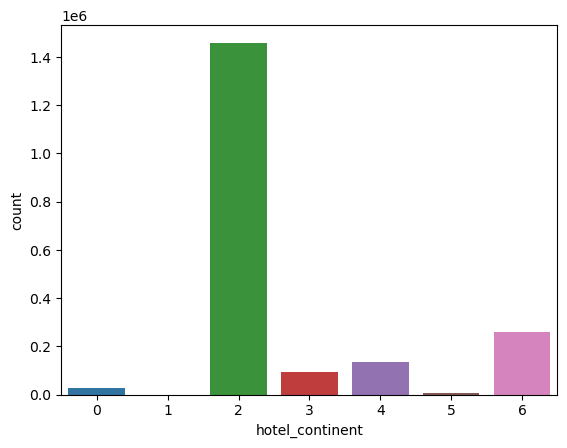

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='hotel_continent', data=df) # can use other columns/attributes here to generate other column charts

<Axes: >

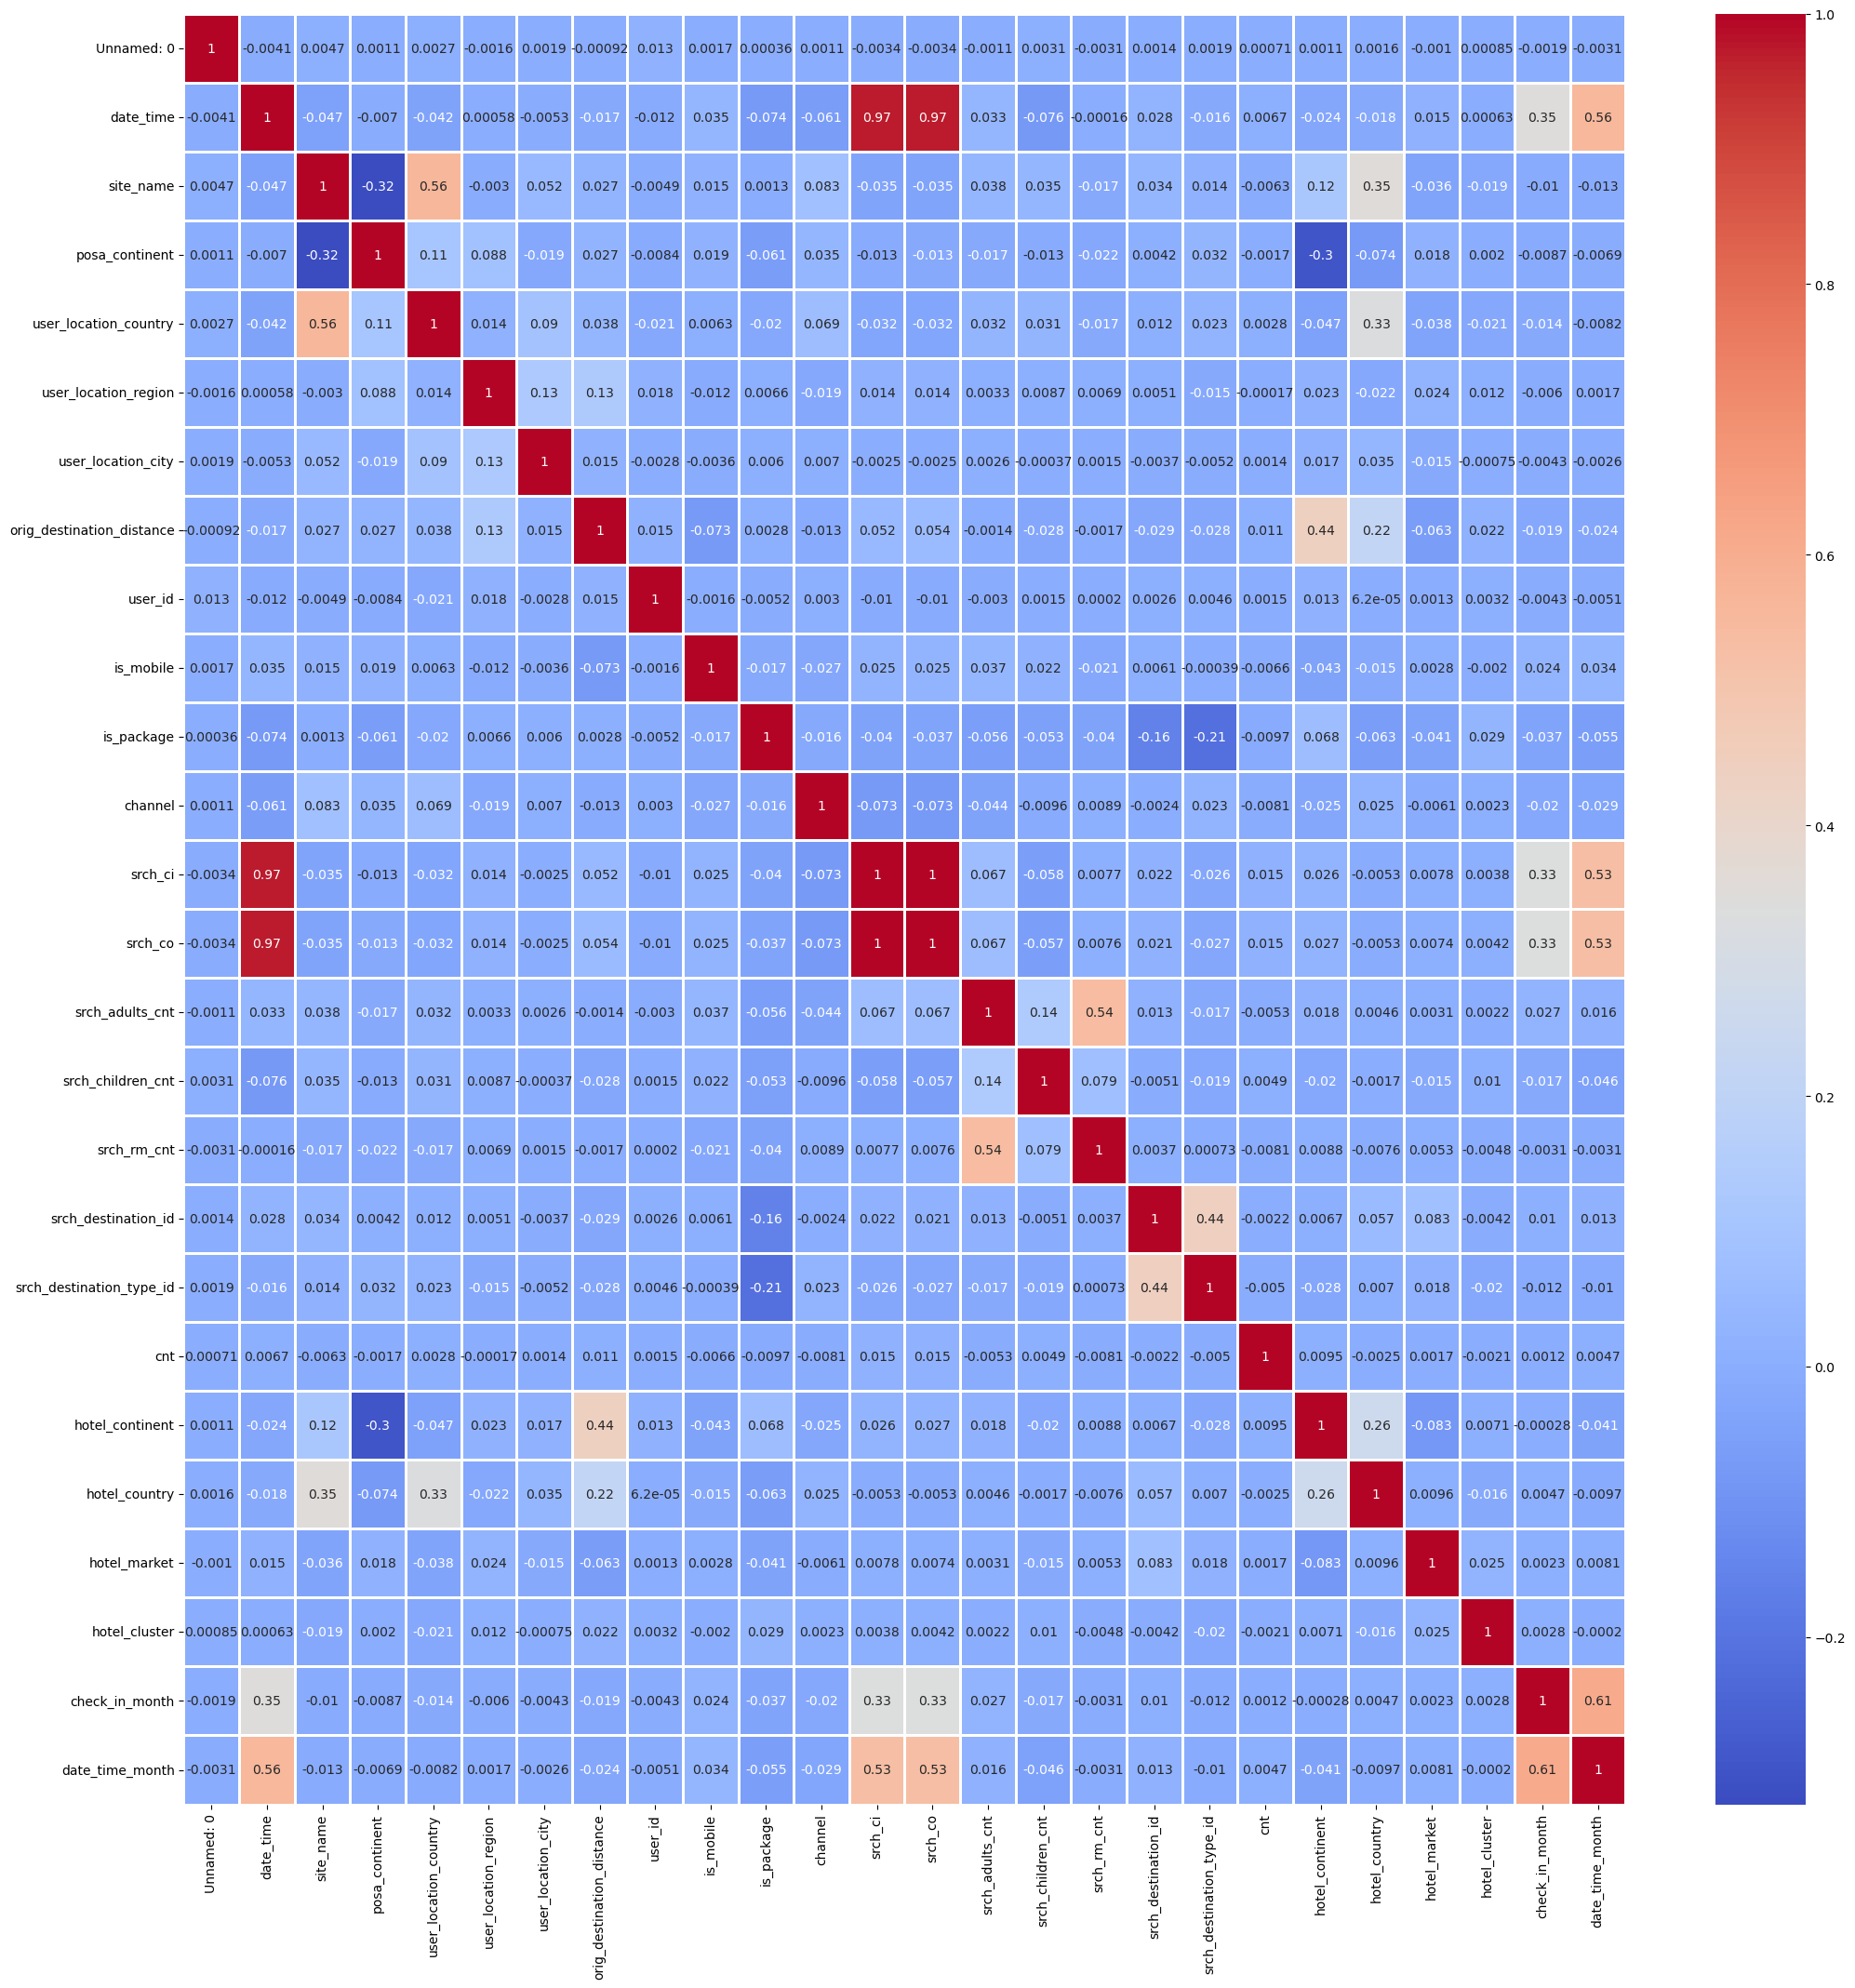

In [13]:
fig, ax=plt.subplots()
fig.set_size_inches(25,25)
sns.heatmap(df.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

<Axes: xlabel='hotel_cluster', ylabel='count'>

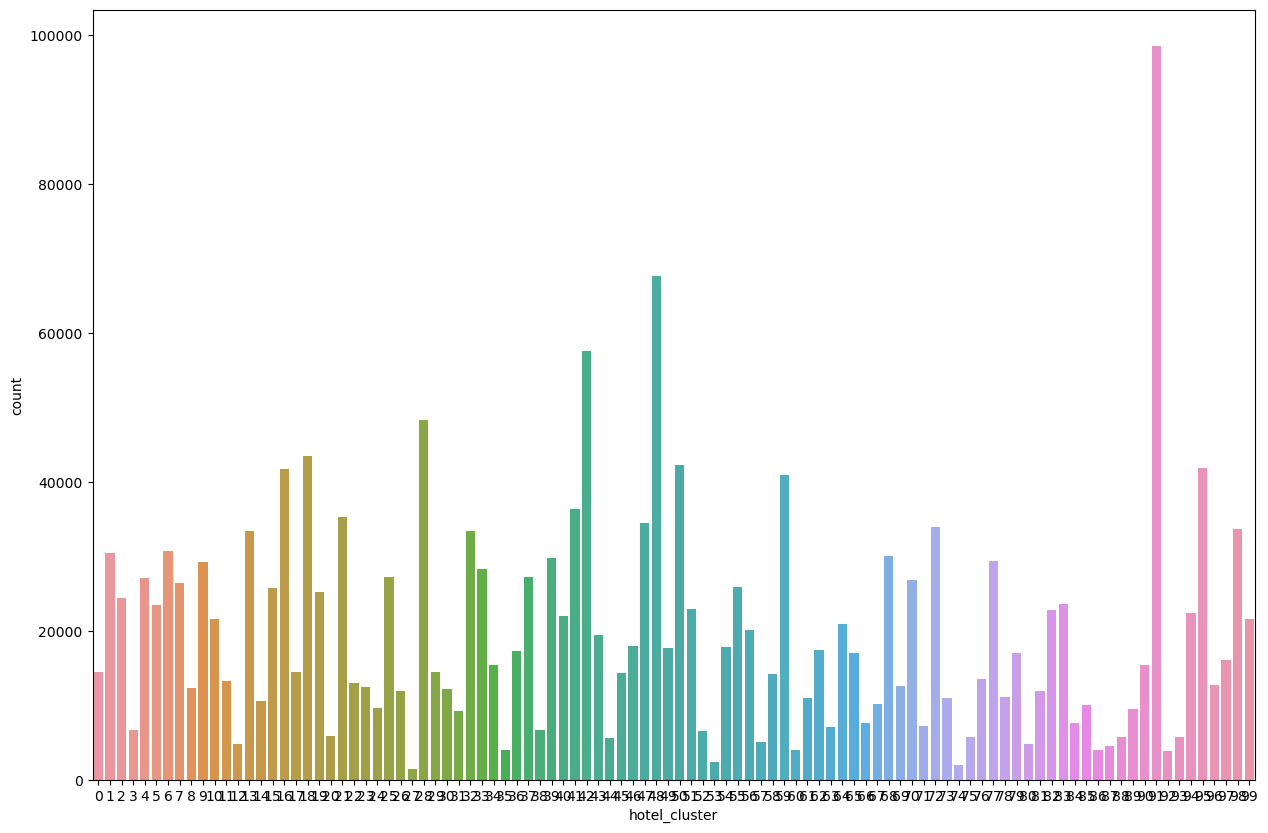

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x='hotel_cluster',data=df, ax=ax)

<Axes: xlabel='is_package', ylabel='count'>

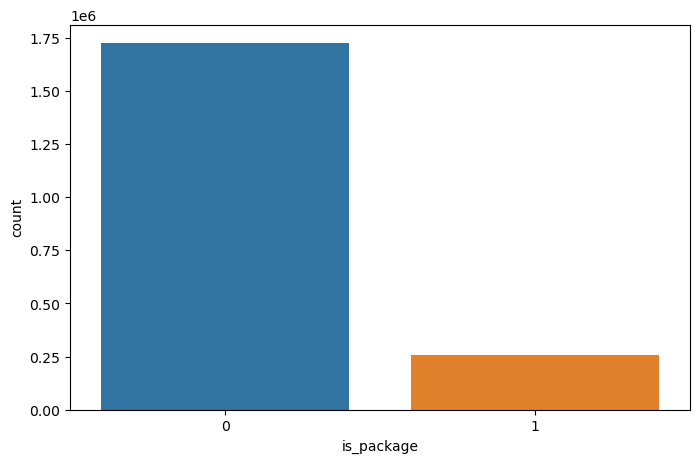

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.countplot(x='is_package',data=df, order=[0,1], ax=ax) #can use other columns/attributes here to generate other column charts

In [16]:
#Calculating the days Spent Columns
df['time_delta']=(df['srch_co']-df['srch_ci'])
df['days_spent']=df['time_delta'].dt.days
df=df.drop(columns=['time_delta'])

In [17]:
df=pd.DataFrame(df)

In [18]:
#Dropping unnecessary Columns
df=df.drop(columns=['user_id']) #--user_id
df=df.drop(columns=['date_time'])#--date_time as the month is already used previously for checking seasonality
df=df.drop(columns=['srch_ci']) #--Check_in --- Accounted in days_spent
df=df.drop(columns=['srch_co']) #--Check_out --- Accounted in days_spent
df=df.drop(columns=['cnt']) #--User_event_count
df=df.drop(columns=['Unnamed: 0']) #--Generated Column

In [19]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,hotel_cluster,check_in_month,date_time_month,days_spent
0,2,3,66,348,48862,2234.2641,0,1,9,2,...,1,8250,1,2,50,628,1,8,8,4
1,2,3,66,462,41898,2454.8588,0,1,1,3,...,2,12009,1,2,50,680,95,2,1,5
2,2,3,66,462,41898,2454.8588,0,1,1,2,...,1,12009,1,2,50,680,95,2,1,5
3,2,3,66,462,41898,2454.8588,0,1,1,2,...,1,12009,1,2,50,680,95,2,1,3
4,2,3,66,174,40365,8456.8294,0,0,0,2,...,2,1571,3,3,5,89,38,11,10,1


In [20]:
df_small = df.head(n = 600000)

In [21]:
#Target encoding the Categorical Variables
# Assuming 'target' is your target variable, replace it with your actual target variable name
target = df_small['hotel_cluster']

# List of categorical columns
categorical_columns = [
     'site_name', 'posa_continent', 'user_location_country',
    'user_location_region', 'user_location_city',
    'channel', 'srch_destination_id', 'srch_destination_type_id',
    'hotel_continent', 'hotel_country', 'hotel_market','check_in_month','date_time_month'
]

In [22]:
# Step 1: Split the dataset into training and validation/test sets
train_df, val_test_df, train_target, val_test_target = train_test_split(df_small, target, test_size = 0.20, random_state = 42)

# Step 2: Specify all categorical columns and calculate the mean of the target variable
encoder = ce.TargetEncoder(cols=categorical_columns)
train_df_encoded = encoder.fit_transform(train_df, train_target)

# Step 3: Map the means back to the original data for the validation/test set
val_test_df_encoded = encoder.transform(val_test_df)

# Print the encoded columns for the training and validation/test sets
print(train_df_encoded[categorical_columns])
print(val_test_df_encoded[categorical_columns])


        site_name  posa_continent  user_location_country  \
501294  47.744371       47.391297              48.791760   
285039  47.744371       47.391297              47.671270   
47556   45.623015       47.391297              45.770463   
580653  47.744371       47.391297              47.671270   
547794  47.744371       47.391297              47.671270   
...           ...             ...                    ...   
110268  47.744371       47.391297              47.671270   
259178  45.623015       47.391297              45.770463   
365838  47.744371       47.391297              47.671270   
131932  47.744371       47.391297              47.671270   
121958  47.744371       47.391297              47.671270   

        user_location_region  user_location_city    channel  \
501294             49.492803           49.492803  47.530525   
285039             48.258640           49.308295  48.285901   
47556              45.539499           47.149679  47.530525   
580653             47.94516

In [23]:
len(train_df_encoded)

480000

In [21]:
#----Standardizing all the values------#

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Assuming train_df and test_df are your datasets after target encoding
scaler = MinMaxScaler()  # or StandardScaler()

train_df_normalized = scaler.fit_transform(train_df)
test_df_normalized = scaler.transform(val_test_df)

<Axes: >

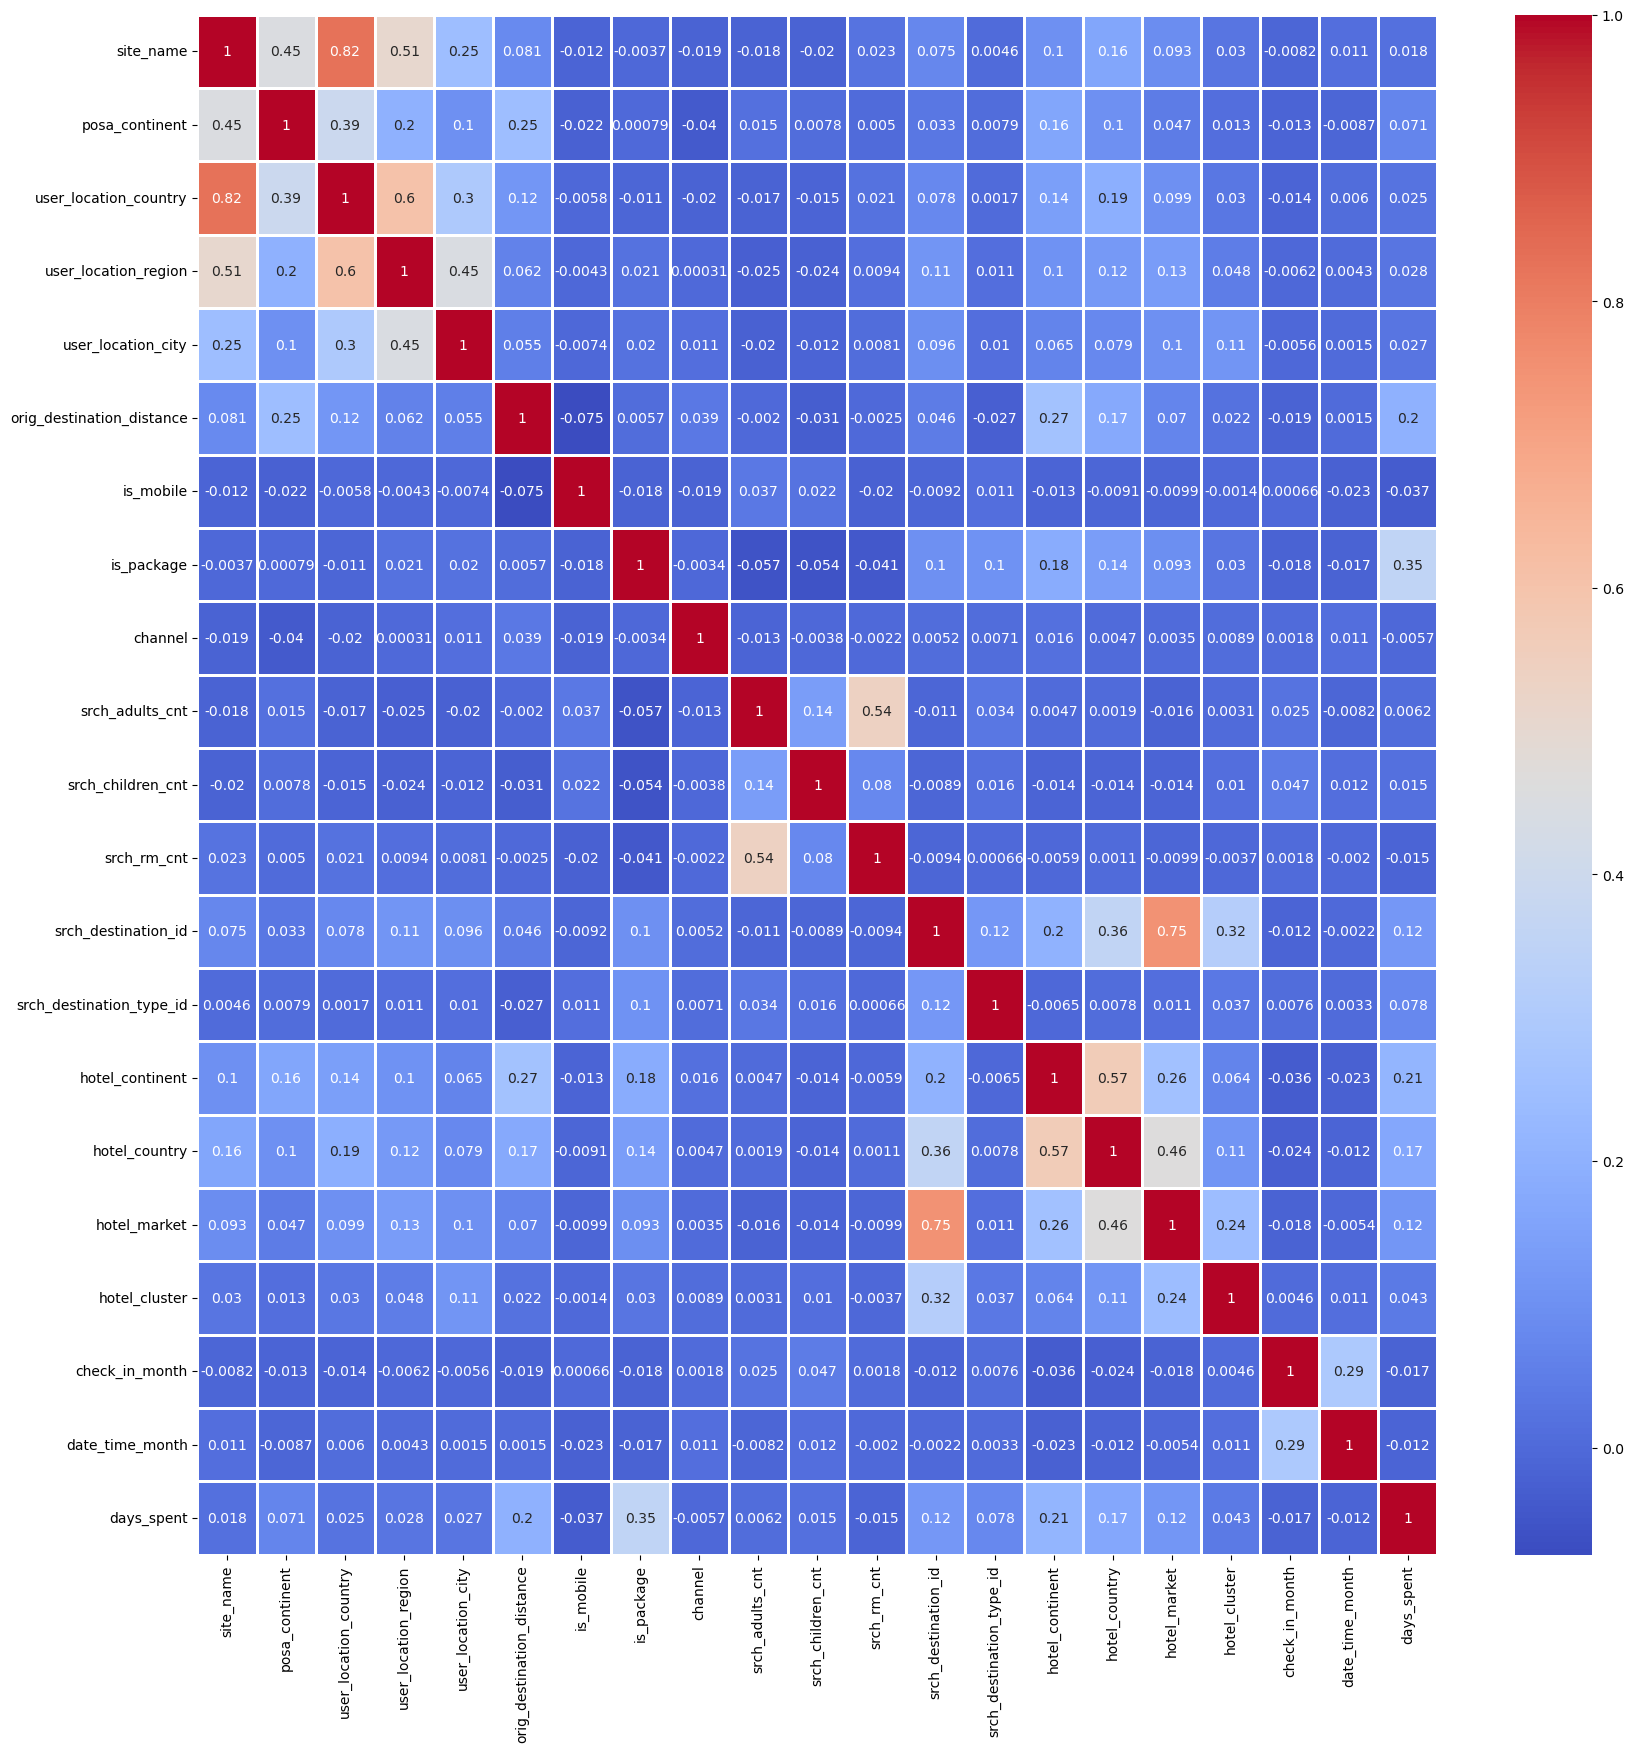

In [25]:
fig, ax=plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(train_df_encoded.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2) #correlation matrix with feature engineering

In [24]:
#----Standardizing all the values------#

In [ ]:
#------------------XG Boost----------------#

In [ ]:
!pip install xgboost

In [33]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report

In [39]:
# Create XGBoost classifier
xg_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=100, colsample_bytree=0.3, learning_rate=0.1,
                           max_depth=5, alpha=10, n_estimators=10)

# Fit the model to the training set
xg_clf.fit(train_df_normalized,train_target)

# Predictions on the test set
y_pred = xg_clf.predict(test_df_normalized)

# Evaluate the model using accuracy and classification report
# Evaluate the model
accuracy = accuracy_score(val_test_target, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional classification report
print(classification_report(val_test_target, y_pred))

Accuracy: 0.98


C:\Users\vaibhav.bodhe\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       888
           1       0.98      0.99      0.99      1869
           2       0.95      1.00      0.97      1538
           3       1.00      1.00      1.00       388
           4       1.00      1.00      1.00      1646
           5       1.00      1.00      1.00      1464
           6       1.00      1.00      1.00      1852
           7       1.00      1.00      1.00      1590
           8       0.95      0.99      0.97       720
           9       1.00      1.00      1.00      1794
          10       1.00      1.00      1.00      1307
          11       1.00      1.00      1.00       801
          12       1.00      1.00      1.00       320
          13       1.00      1.00      1.00      1981
          14       1.00      1.00      1.00       647
          15       1.00      1.00      1.00      1648
          16       1.00      1.00      1.00      2496
          17       1.00    

C:\Users\vaibhav.bodhe\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vaibhav.bodhe\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report


# Step 1: Split the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(df_small, target, test_size=0.3, random_state=42)

# Step 2: Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Print the sizes of the resulting sets
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Create XGBoost classifier
xg_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=100, colsample_bytree=0.3, learning_rate=0.1,
                           max_depth=5, alpha=10, n_estimators=10)

# Step 4: Train the model on the training set
xg_clf.fit(X_train, y_train)

# Step 5: Make predictions on the validation set
y_val_pred = xg_clf.predict(X_val)

# Step 6: Evaluate the model on the validation set using K-fold cross-validation
num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(xg_clf, X_val, y_val, cv=stratified_kfold, scoring='accuracy')

# Display cross-validation results
print(f'Cross-Validation Accuracy on Validation Set: {cv_results.mean():.2f} +/- {cv_results.std():.2f}')

# Step 7: Make predictions on the test set
y_test_pred = xg_clf.predict(X_test)

# Step 8: Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {accuracy_test:.2f}')

# Additional classification report for the test set
print(classification_report(y_test, y_test_pred))


Training set size: 420000
Validation set size: 90000
Test set size: 90000
Cross-Validation Accuracy on Validation Set: 0.98 +/- 0.00
Test Accuracy: 0.98


C:\Users\vaibhav.bodhe\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       623
           1       0.98      0.98      0.98      1396
           2       0.94      1.00      0.97      1124
           3       1.00      1.00      1.00       309
           4       1.00      1.00      1.00      1231
           5       1.00      1.00      1.00      1125
           6       1.00      1.00      1.00      1371
           7       1.00      1.00      1.00      1222
           8       0.96      0.98      0.97       526
           9       1.00      1.00      1.00      1351
          10       1.00      1.00      1.00       970
          11       1.00      1.00      1.00       624
          12       1.00      1.00      1.00       233
          13       1.00      1.00      1.00      1476
          14       1.00      1.00      1.00       486
          15       1.00      1.00      1.00      1196
          16       1.00      1.00      1.00      1940
          17       1.00    

C:\Users\vaibhav.bodhe\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vaibhav.bodhe\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#------------------XGBoost ------------#

In [25]:
#----Trying out the model------#

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model=RandomForestClassifier(n_estimators = 25)
rf_model.fit(train_df,train_target)
y_pred_rf=rf_model.predict(val_test_df)
accuracy = accuracy_score(val_test_target, y_pred_rf)

# Print the accuracy
print("Accuracy:", accuracy)

In [26]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': df.columns,
    'Importance': rf_model.feature_importances_
})

NameError: name 'rf_model' is not defined

In [ ]:
# Sort features by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the top N features and their importance scores
top_n = 30  # Change this value based on your preference
print(f"\nTop {top_n} Features:")
print(feature_importance.head(top_n))

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming train_df contains your training features and train_target contains the corresponding labels
logistic_model = LogisticRegression()
logistic_model.fit(train_df_normalized, train_target)

# Assuming val_test_df contains your validation/test features
y_pred_logistic = logistic_model.predict(test_df_normalized)
# Evaluate the performance of the logistic regression model
accuracy = accuracy_score(val_test_target, y_pred_logistic)
classification_rep = classification_report(val_test_target, y_pred_logistic)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

/Users/dhritipatani/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.3061
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.17      0.20       888
           1       0.43      0.93      0.59      1869
           2       0.48      0.46      0.47      1538
           3       0.00      0.00      0.00       388
           4       0.29      0.31      0.30      1646
           5       0.30      0.16      0.21      1464
           6       0.30      0.21      0.25      1852
           7       0.30      0.49      0.37      1590
           8       0.26      0.26      0.26       720
           9       0.32      0.31      0.31      1794
          10       0.42      0.06      0.11      1307
          11       0.32      0.25      0.28       801
          12       0.16      0.10      0.12       320
          13       0.42      0.40      0.41      1981
          14       0.12      0.01      0.01       647
          15       0.30      0.13      0.18      1648
          16       0.28      0.36      0

/Users/dhritipatani/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dhritipatani/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dhritipatani/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
# Initialize logistic regression model
logreg_model = LogisticRegression()

# Track accuracy for each feature added
accuracies = []

# Iterate through features and record accuracy
for feature in train_df.columns:
    # Add the next feature to the training set
    train_df_temp = train_df[[feature]]
    val_test_df_temp = val_test_df[[feature]]
   
    # Fit the logistic regression model
    logreg_model.fit(train_df_temp, train_target)
   
    # Make predictions
    y_pred = logreg_model.predict(val_test_df_temp)
   
    # Calculate accuracy
    accuracy = accuracy_score(val_test_target, y_pred)
   
    # Append accuracy to the list
    accuracies.append((feature, accuracy))
   
    # Print the current feature and accuracy
    print(f"Added feature: {feature}, Accuracy: {accuracy}")

# Find the feature where accuracy is highest
best_feature, best_accuracy = max(accuracies, key=lambda x: x[1])

# Print the best feature and accuracy
print(f"\nBest Feature: {best_feature}, Best Accuracy: {best_accuracy}")

In [ ]:
!pip install auto-sklearn

In [ ]:
# Auto ML
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

# Create and fit an AutoML classifier
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(train_df_normalized, train_target)

# Make predictions
predictions = automl.predict(test_df_normalized)

# Evaluate the model
accuracy = sklearn.metrics.accuracy_score(val_test_target, predictions)
print(f"Accuracy: {accuracy}")

In [ ]:
#import KNeighborsClassifier and matplotlib
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
neighbors = np.arange(1,19,2)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [ ]:
for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    #Fit the model
    knn.fit(train_df_normalized, train_target)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(train_df_normalized, train_target)

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(test_df_normalized, val_test_target)

In [ ]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#From the above plot, we get the optimal k = 3

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming train_df contains your training features and train_target contains the corresponding labels
knn_model = KNeighborsClassifier(n_neighbors = 3)  # You can adjust the number of neighbors (n_neighbors) as needed
knn_model.fit(train_df_normalized, train_target)
# Assuming test_df_normalized contains your validation/test features
y_pred_knn = knn_model.predict(test_df_normalized)

# Evaluate the performance of the KNN model
accuracy = accuracy_score(val_test_target, y_pred_knn)
print(f"Accuracy: {accuracy:.2f}")

# # Print a classification report for more detailed performance metrics
# print("Classification Report:")
# print(classification_report(val_test_target, y_pred_knn))

In [ ]:
!pip install dmba

In [29]:
import math
from sklearn.metrics import roc_curve, auc
from dmba import regressionSummary, classificationSummary
from dmba import liftChart, gainsChart

no display found. Using non-interactive Agg backend


In [30]:
# train linear regression model
reg = LogisticRegression()
reg.fit(train_df, train_target)

# evaluate performance
# training
regressionSummary(train_target, reg.predict(train_df))
# validation
regressionSummary(val_test_target, reg.predict(val_test_df))

/Users/dhritipatani/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regression statistics

               Mean Error (ME) : -37.9236
Root Mean Squared Error (RMSE) : 49.4822
     Mean Absolute Error (MAE) : 41.3155

Regression statistics

               Mean Error (ME) : -37.9707
Root Mean Squared Error (RMSE) : 49.5106
     Mean Absolute Error (MAE) : 41.3447
